# 5. Train CNN with Transformer


In this notebook, we will build off `Train_CNN_Model.ipynb` and incorporate a Transformer layer after the CNN blocks.

Limitations of CNN
- While CNNs are effective at capturing local patterns and features through convolutions, they might struggle with long-range dependencies and interactions between distant features.

Why Transformers
- Through self-attention, transformers can capture relationships between distant positions in the input sequence.
- After CNNs have extracted features, transformers can further refine and enhance these features by considering the context provided by the entire sequence

Considerations
- Increased model complexity. With additional parameters to learn, we must be careful of overfitting. For this notebook, I found it helpful to reduce the number for CNN layers from 3 to 2


In [2]:
from TelescopeML.DataMaster import *
from TelescopeML.CNNTransformerTrainer import *
from TelescopeML.Predictor import *
from TelescopeML.IO_utils import load_or_dump_trained_model_CNN
from TelescopeML.StatVisAnalyzer import *

## 3.1 Data Preperation 

### 3.1.1 Load the Synthetic spectra - training dataset

We computed a low-resolution spectrum ($R$=200) utilizing atmopshric brown dwarfs grid model, [*Sonora-Bobcat*](https://arxiv.org/pdf/2107.07434.pdf) for spectral range $\sim$0.9-2.4 $\mu m$. An open-source atmospheric radiative transfer Python package, [*PICASO*](https://natashabatalha.github.io/picaso/) was employed for generating these datasets. This dataset encompass 30,888 synthetic spectra (or instances or rows). 


Each spectrum has 104 wavelengths (i.e., 0.897, 0.906, ..., 2.512 μm) and 4 output atmospheric parameters:

- gravity (log *g*)
- temperature (*T*<sub>eff</sub>)
- carbon-to-oxygen ratio (C/O)
- metallicity ([M/H])


In [3]:
import os 

__reference_data_path__ = os.getenv("TelescopeML_reference_data")
__reference_data_path__ 


# Note: insert the directory of the reference_data if you get an error reading the reference data!!!
# __reference_data_path__ = 'INSERT_DIRECTORY_OF_reference_data'


'/Users/tulingma/workspace/TelescopeML_project/reference_data/'

 Load the dataset and check few instances 

In [4]:
train_BD = pd.read_csv(os.path.join(__reference_data_path__, 
                                    'training_datasets', 
                                    'browndwarf_R100_v4_newWL_v3.csv.bz2'), compression='bz2')
train_BD.head()

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.981,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08
3,5.0,1100,0.25,-0.3,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08
4,5.0,1100,0.25,0.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08


### 3.1.2 Check atmospheric parameters


- gravity (log *g*)
- temperature (*T*<sub>eff</sub>)
- carbon-to-oxygen ratio (C/O)
- metallicity ([M/H])

In [5]:
output_names = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']
train_BD[output_names].head()

,gravity,temperature,c_o_ratio,metallicity
0,5.0,1100,0.25,-1.0
1,5.0,1100,0.25,-0.7
2,5.0,1100,0.25,-0.5
3,5.0,1100,0.25,-0.3
4,5.0,1100,0.25,0.0


In [6]:
wavelength_names = [item for item in train_BD.columns.to_list() if item not in output_names]
wavelength_names[:5]

['2.512', '2.487', '2.462', '2.438', '2.413']

In [7]:
wavelength_values = [float(item) for item in wavelength_names]
wavelength_values[:10]

[2.512, 2.487, 2.462, 2.438, 2.413, 2.389, 2.366, 2.342, 2.319, 2.296]

In [8]:
wl_synthetic = pd.read_csv(os.path.join(__reference_data_path__, 
                                        'training_datasets', 
                                        'wl.csv'))
wl_synthetic.head()

,wl
0,2.511960
1,2.486966
2,2.462220
3,2.437720
4,2.413464


### 3.1.3 Prepare Inputs and outputs for ML models (X,y)
- X: 104 wavelengths and their corresponding flux values 
- y: output variables: 'gravity', 'temperature',  'c_o_ratio', 'metallicity'

In [9]:
# Training  variables
X = train_BD.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity'])


# Target/Output feature variables
y = train_BD[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]


log-transform the 'temperature' variable toreduce the skewness of the data, making it more symmetric and normal-like for the ML model


In [10]:
y.loc[:, 'temperature'] = np.log10(y['temperature'])

---

## 3.2 Build the CNN model and Processing the Data

Here we instintiate BuildRegressorCNN class from DeepBuilder module to prepare the datasets and take the trained CNN (Convolutional Neural Networks) for us:

- Take the synthetic datasets
- Process them, e.g.
    - Divide them to three sets: train, validation, and test sets
    - Scale y variables
    - Scale X variables
    - Create new features 
    

### 3.2.1 Instintiate BuildRegressorCNN class from DeepBuilder module

In [11]:
data_processor = DataProcessor( 
                                 flux_values=X.to_numpy(),
                                 wavelength_names=X.columns,
                                 wavelength_values=wavelength_values,
                                 output_values=y.to_numpy(),
                                 output_names=output_names,
                                 spectral_resolution=200,
                                 trained_ML_model=None,
                                 trained_ML_model_name='CNN_Transformer',
                                )

### 3.2.2 Split the dataset into train, validate and test sets

In [12]:
data_processor.split_train_validation_test(test_size=0.1, 
                                             val_size=0.1, 
                                             random_state_=42,)

### 3.2.3 Standardize X Variables Row-wise 

In [13]:
# Scale the X features using MinMax Scaler
data_processor.standardize_X_row_wise()

### 3.2.4 Standardize y Variables Column-wise 

In [14]:
# Standardize the y features using Standard Scaler
data_processor.standardize_y_column_wise()

### 3.2.5 Feature engeenering: Take Min and Max of each row (BD spectra) 

In [15]:
# train
data_processor.X_train_min = data_processor.X_train.min(axis=1)
data_processor.X_train_max = data_processor.X_train.max(axis=1)

# validation
data_processor.X_val_min = data_processor.X_val.min(axis=1)
data_processor.X_val_max = data_processor.X_val.max(axis=1)

# test
data_processor.X_test_min = data_processor.X_test.min(axis=1)
data_processor.X_test_max = data_processor.X_test.max(axis=1)

In [16]:
df_MinMax_train = pd.DataFrame((data_processor.X_train_min, data_processor.X_train_max)).T
df_MinMax_val = pd.DataFrame((data_processor.X_val_min, data_processor.X_val_max)).T
df_MinMax_test = pd.DataFrame((data_processor.X_test_min, data_processor.X_test_max)).T

In [17]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)
df_MinMax_val.rename(columns={0:'min', 1:'max'}, inplace=True)
df_MinMax_test.rename(columns={0:'min', 1:'max'}, inplace=True)

### 3.2.6 Scale Min Max features - ColumnWise

In [18]:
data_processor.standardize_X_column_wise(
                                        output_indicator='Trained_StandardScaler_X_ColWise_MinMax',
                                        X_train = df_MinMax_train.to_numpy(),
                                        X_val   = df_MinMax_val.to_numpy(),
                                        X_test  = df_MinMax_test.to_numpy(),
                                        )

## 3.3 Train CNN Transformer model

### 3.3.1 Instantiate *TrainCNNTransformer* class from *CNNTransformerTrainer* Module

In [19]:
train_cnn_transformer_model = TrainCNNTransformer(
            # input dataset: StandardScaled instances  
            X1_train = data_processor.X_train_standardized_rowwise,
            X1_val   = data_processor.X_val_standardized_rowwise,
            X1_test  = data_processor.X_test_standardized_rowwise,

            # input dataset: Min Max of each instance  
            X2_train = data_processor.X_train_standardized_columnwise,
            X2_val   = data_processor.X_val_standardized_columnwise,
            X2_test  = data_processor.X_test_standardized_columnwise,


            # 1st target
            y1_train = data_processor.y_train_standardized_columnwise[:,0],
            y1_val   = data_processor.y_val_standardized_columnwise[:,0],
            y1_test  = data_processor.y_test_standardized_columnwise[:,0],

            # 2nd target
            y2_train = data_processor.y_train_standardized_columnwise[:,1],
            y2_val   = data_processor.y_val_standardized_columnwise[:,1],
            y2_test  = data_processor.y_test_standardized_columnwise[:,1],

            # 3rd target
            y3_train = data_processor.y_train_standardized_columnwise[:,2],
            y3_val   = data_processor.y_val_standardized_columnwise[:,2],
            y3_test  = data_processor.y_test_standardized_columnwise[:,2],

            # 4th target
            y4_train = data_processor.y_train_standardized_columnwise[:,3],
            y4_val   = data_processor.y_val_standardized_columnwise[:,3],
            y4_test  = data_processor.y_test_standardized_columnwise[:,3],
            )

### 3.3.2 Define the Hyperparameters

In [20]:
hyperparameters = {
         'Conv__MaxPooling1D': 3,
         'Conv__NumberBlocks': 2,
         'Conv__NumberLayers': 2,
         'Conv__filters': 32,
         'Conv__kernel_size': 4,
         'Trans__NumberBlocks': 1,
         'Trans__NumberHeads': 4,
         'Trans__dropout': 0.2,
         'FC1__NumberLayers': 3,
         'FC1__dropout': 0.0013358917126831819,
         'FC1__units': 256,
         'FC2__NumberBlocks': 1,
         'FC2__NumberLayers': 4,
         'FC2__dropout': 0.0018989744374361271,
         'FC2__units': 128,
         'lr': 0.00018890368162236508
                 }

### 3.3.3 Build a CNN Transformer model

In [21]:
train_cnn_transformer_model.build_model(config=hyperparameters, )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 104, 1)]             0         []                            
                                                                                                  
 Conv__B1_L1 (Conv1D)        (None, 104, 32)              160       ['input_1[0][0]']             
                                                                                                  
 Conv__B1_L2 (Conv1D)        (None, 104, 128)             16512     ['Conv__B1_L1[0][0]']         
                                                                                                  
 Conv__B1__MaxPooling1D (Ma  (None, 34, 128)              0         ['Conv__B1_L2[0][0]']         
 xPooling1D)                                                                                  

### 3.3.4 Train the CNN transformer model using the datasets

In [21]:
history, model =  train_cnn_transformer_model.fit_cnn_model(batch_size=1000,
                                                budget=100)

Epoch 1/100
26/26 [==============================] - 12s 402ms/step - loss: 1.3172 - output__gravity_loss: 0.5025 - output__c_o_ratio_loss: 0.3509 - output__metallicity_loss: 0.2937 - output__temperature_loss: 0.1700 - output__gravity_mae: 0.8881 - output__c_o_ratio_mae: 0.7136 - output__metallicity_mae: 0.6325 - output__temperature_mae: 0.4199 - val_loss: 0.6462 - val_output__gravity_loss: 0.3105 - val_output__c_o_ratio_loss: 0.1490 - val_output__metallicity_loss: 0.1586 - val_output__temperature_loss: 0.0281 - val_output__gravity_mae: 0.6628 - val_output__c_o_ratio_mae: 0.4341 - val_output__metallicity_mae: 0.4539 - val_output__temperature_mae: 0.1916
Epoch 2/100
26/26 [==============================] - 11s 409ms/step - loss: 0.5625 - output__gravity_loss: 0.2449 - output__c_o_ratio_loss: 0.1392 - output__metallicity_loss: 0.1534 - output__temperature_loss: 0.0251 - output__gravity_mae: 0.5763 - output__c_o_ratio_mae: 0.4164 - output__metallicity_mae: 0.4466 - output__temperature_mae

### 3.3.5 Check the Trained CNN Transformer Architecture and Summary

Checking the architecture of a CNN and its summary is importnat because it provide insights about: 
- Model Design and Structure
- Model complexity
- Hyperparameter Tuning:

In [ ]:
data_processor.trained_ML_model = model
data_processor.history = history

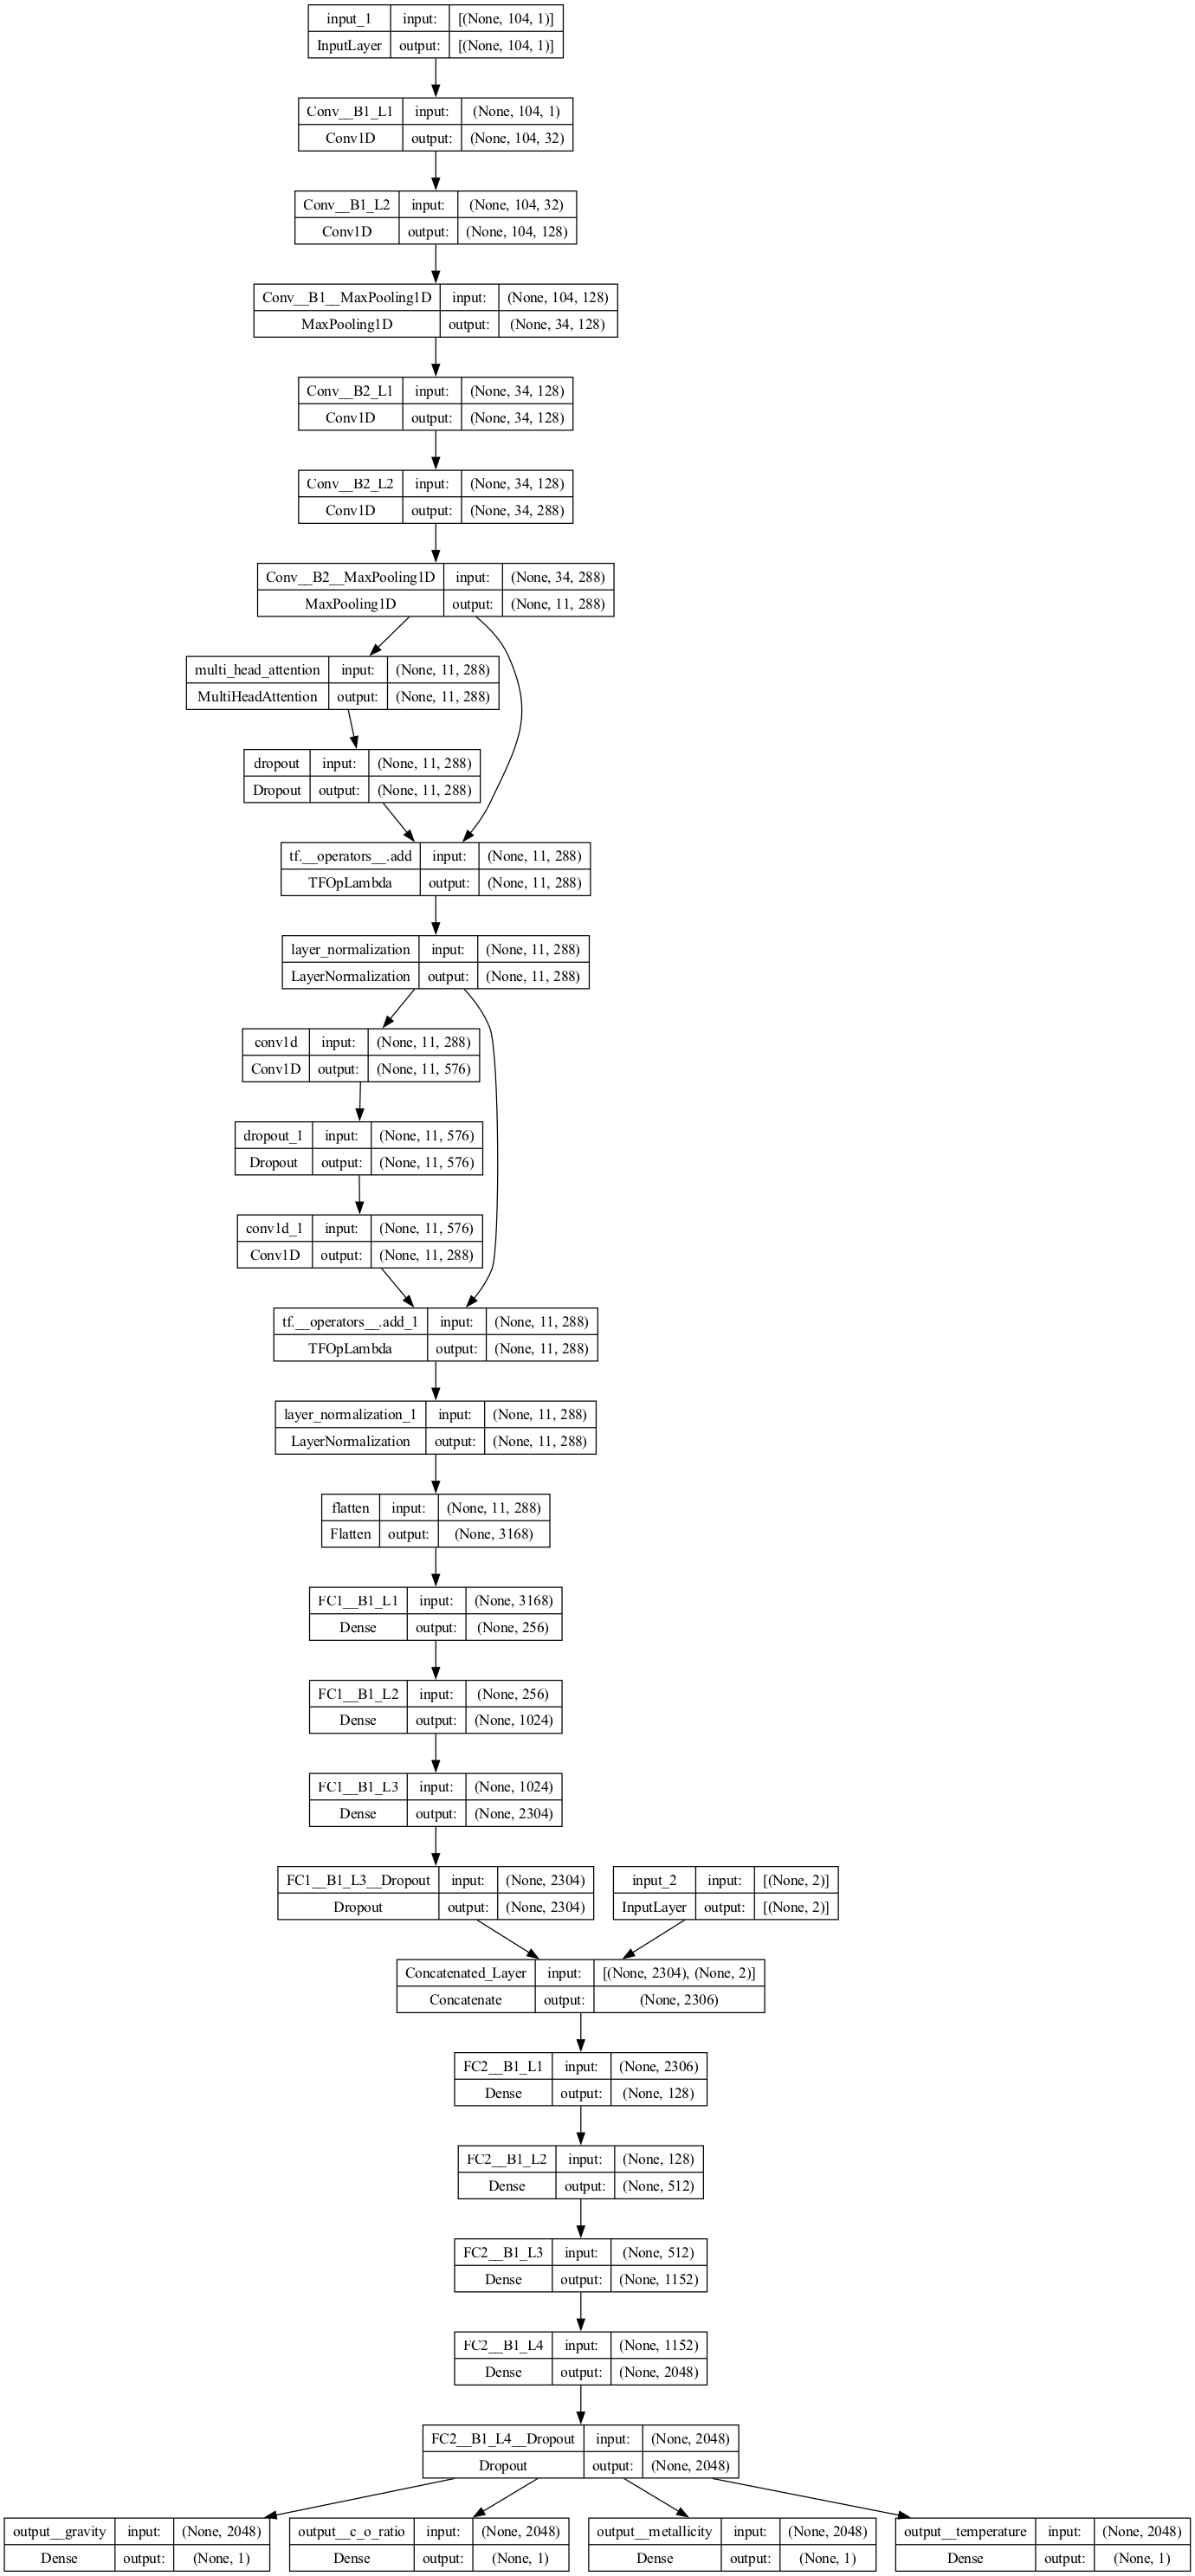

In [23]:
tf.keras.utils.plot_model(
                    train_cnn_transformer_model.model,
                    to_file="model.png",
                    show_shapes=True,
                    show_dtype=False,
                    show_layer_names=True,
                    rankdir="TB",
                    expand_nested=True,
                    dpi=90,
                    layer_range=None,
                        )

### 3.3.6 Trained Model Outcomes

Save output of trained model

In [24]:
load_or_dump_trained_model_CNN( trained_model = data_processor,
                                                        output_indicator='tuned_bohb_batch32_v3_1000epoch_out100_transformer_TEST2',
                                                        load_or_dump = 'dump')

/opt/anaconda3/envs/TelescopeML/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 3.4 Check the performance of the Trained Model

### 3.4.1 Load the Saved Trained CNN Models

In [24]:
loaded_model, history = load_or_dump_trained_model_CNN(output_indicator='tuned_bohb_batch32_v3_1000epoch_out100_transformer_TEST',
                                                      load_or_dump = 'load')

In [25]:
train_cnn_transformer_model.trained_model = model
train_cnn_transformer_model.trained_model_history = history

### 3.4.3  Check the training history through *Loss* metric

In [26]:
# train_cnn_model.trained_model_history
plot_ML_model_loss_bokeh(trained_ML_model_history = train_cnn_transformer_model.trained_model_history,
                title = 'Hyperparameter-Tuned CNN Transformer model')

---

In [32]:
loaded_model_base, history_base = load_or_dump_trained_model_CNN(output_indicator='tuned_bohb_batch32_v3_1000epoch_out10',
                                                      load_or_dump = 'load')

### 3.4.4  Plot training history through baseline CNN model

In [33]:
plot_ML_model_loss_bokeh_with_baseline(trained_ML_model_history = train_cnn_transformer_model.trained_model_history, base_model_history = history_base,
                title = 'Hyperparameter-Tuned CNN Transformer model against baseline CNN model')